In [ ]:
import os, joblib, numpy as np, pandas as pd, matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

import xgboost as xgb
import numpy as np

# Training an XGBoost model

### Objectives: Since the resnet backend was achieving 99.3% accuracy, let's aim for 99.5%

### Loading and splitting the final dataset

In [ ]:
csv_path = os.path.join(os.getcwd(), "data", "final.csv")
df = pd.read_csv(csv_path)

label_col = "label" if "label" in df.columns else df.columns[-1]
feature_cols = [str(i) for i in range(512)] if all(str(i) in df.columns for i in range(512)) else df.select_dtypes(include=[np.number]).columns.drop(label_col)

X = df[feature_cols].values
y_raw = df[label_col].values
le = LabelEncoder()
y = le.fit_transform(y_raw)

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

### Hyperparameter tuning

In [ ]:
params = {
    "objective": "multi:softprob" if len(np.unique(y)) > 2 else "binary:logistic",      # type: ignore
    "eval_metric": "mlogloss" if len(np.unique(y)) > 2 else "logloss",      # type: ignore
    "eta": 0.05,
    "max_depth": 6,
    "subsample": 0.8,
    "colsample_bytree": 0.8,
    "seed": 42,
    "nthread": 8,
    "verbosity": 1,
}
if len(np.unique(y)) > 2:   # type: ignore
    params["num_class"] = len(np.unique(y))     # type: ignore

### Training the model and printing the stats

In [1]:
dtrain = xgb.DMatrix(X_train, label=y_train)
dval = xgb.DMatrix(X_val, label=y_val)
bst = xgb.train(params, dtrain, num_boost_round=2000, evals=[(dtrain,"train"),(dval,"valid")], early_stopping_rounds=100, verbose_eval=50)

dval_pred = xgb.DMatrix(X_val)
y_prob = bst.predict(dval_pred)
y_pred = np.argmax(y_prob, axis=1) if y_prob.ndim == 2 else (y_prob > 0.5).astype(int)

acc = accuracy_score(y_val, y_pred)
print("Accuracy:", acc)
print(classification_report(y_val, y_pred, target_names=[str(c) for c in le.classes_]))     # type: ignore
cm = confusion_matrix(y_val, y_pred)
print("Confusion matrix:\n", cm)

[0]	train-logloss:0.65024	valid-logloss:0.65063
[50]	train-logloss:0.08338	valid-logloss:0.09300
[100]	train-logloss:0.02534	valid-logloss:0.03826
[150]	train-logloss:0.01055	valid-logloss:0.02419
[200]	train-logloss:0.00513	valid-logloss:0.01868
[250]	train-logloss:0.00274	valid-logloss:0.01601
[300]	train-logloss:0.00157	valid-logloss:0.01478
[350]	train-logloss:0.00095	valid-logloss:0.01413
[400]	train-logloss:0.00062	valid-logloss:0.01386
[450]	train-logloss:0.00042	valid-logloss:0.01381
[500]	train-logloss:0.00030	valid-logloss:0.01383
[535]	train-logloss:0.00024	valid-logloss:0.01387
Accuracy: 0.9961701051414532
              precision    recall  f1-score   support

           0       0.99      1.00      1.00     28921
           1       1.00      0.99      1.00     26433

    accuracy                           1.00     55354
   macro avg       1.00      1.00      1.00     55354
weighted avg       1.00      1.00      1.00     55354

Confusion matrix:
 [[28879    42]
 [  170 26263

### Plotting additional statistics

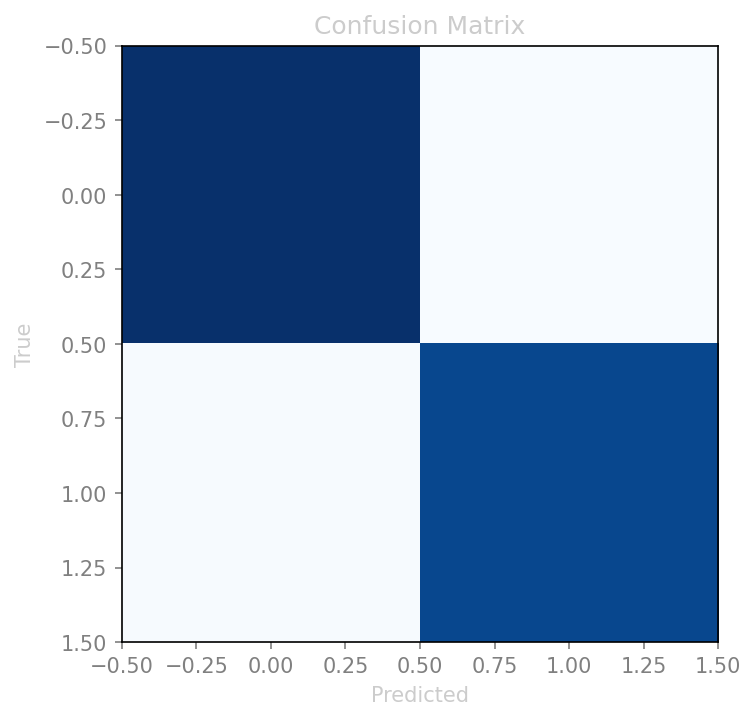

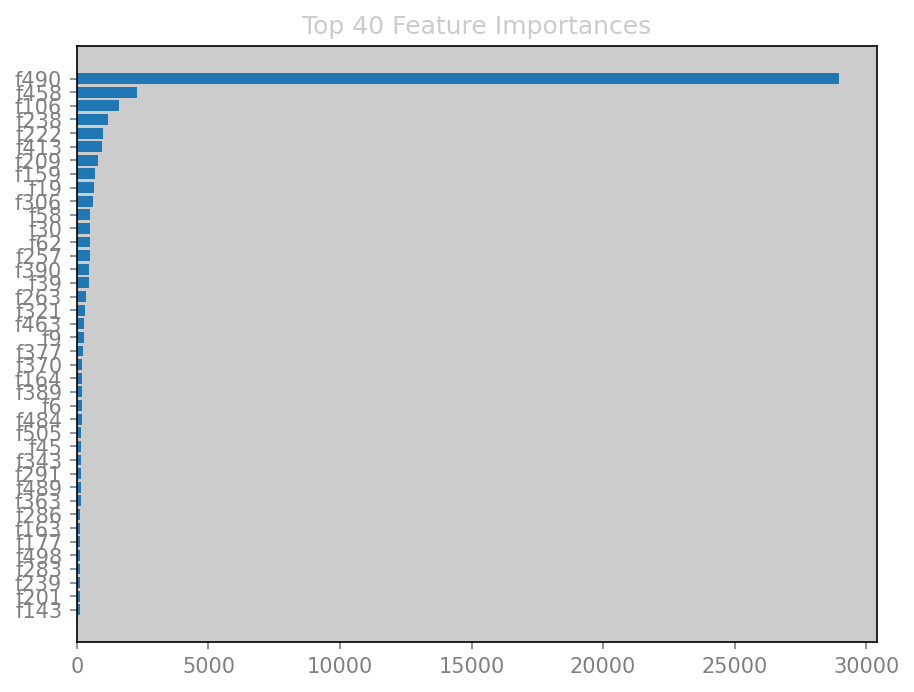

In [2]:
plt.imshow(cm, cmap="Blues")
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()

fs = bst.get_score(importance_type="gain")
items = sorted(fs.items(), key=lambda x: x[1], reverse=True)[:40]
plt.barh([k for k,v in items][::-1], [v for k,v in items][::-1])
plt.title("Top 40 Feature Importances")
plt.show()

### Storing the model

In [3]:
model_dir = os.path.join(os.getcwd(), "models")
os.makedirs(model_dir, exist_ok=True)
model_path = os.path.join(model_dir, "xgb_model.joblib")
joblib.dump({"model": bst, "label_encoder": le, "features": feature_cols}, model_path)
print(f"Model saved to {model_path}")

Model saved to /home/espacio/ml/sem5-proj/models/xgb_model.joblib
